In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gaitFunctions
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [36]:
# plot colors and parameters
axis_fontsize=14
tick_fontsize=12

# color parameters
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7

# Get timing of original videos (can skip down to load data)

In [3]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_exemplaris/')
# list directories within this directory
dirs = []
for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        folder = os.path.join(dirname, subdirname).split('/')[1]
        if folder not in dirs:
            dirs.append(folder)
dirs = np.sort(np.unique(np.array(dirs)))
dirs = [x for x in dirs if 'exemplaris' in x]
folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) # 1,5,8 for exemplaris


Choose from this list (separate by commas if multiple choices): 
1: iw_11Dec23_exemplaris_inverted
2: iw_12Dec22_exemplaris_inverted
3: iw_14Dec22_exemplaris_inverted
4: iw_1Feb23_exemplaris_inverted
5: iw_21Dec23_exemplaris_inverted
6: iw_30Jan23_exemplaris_inverted
7: iw_6Dec22_exemplaris_olympus
8: iw_9Nov23_exemplaris_inverted
9: jb_1Feb23_exemplaris_inverted
10: kt_8Feb23_exemplaris_inverted
11: select ALL

Which number(s) do you want? 1,5,8
You chose: iw_11Dec23_exemplaris_inverted and iw_21Dec23_exemplaris_inverted and iw_9Nov23_exemplaris_inverted


In [4]:
# get durations of videos (in seconds)
# if there is a 'vid_info.csv' file already, then great!
# if not, we need to make this file ... and the videos need to be downloaded on the hard drive
# (if they are in the cloud, this will freeze)

vids = []
video_folder = 'original_videos'
vid_info_file = 'vid_info.csv'
vid_df = pd.DataFrame()

for folder in folders_in_analysis:
    vids_in_folder = []
    have_vid_info = False
    
    # collect names of videos in this folder
    for extension in ['*mp4','*mov']:
        vids_in_folder.extend(glob.glob(os.path.join(folder,video_folder,extension)))
    
    # add names of videos in this folder to overall list
    vids_in_folder = sorted(vids_in_folder)
    vids.extend(vids_in_folder)
    
    # do we already have vid info for this folder?
    vid_info_path = os.path.join(folder,video_folder,vid_info_file)
    if len(glob.glob(vid_info_path)) > 0:
        these_vids_df = pd.read_csv(vid_info_path)
        have_vid_info = True
        print('Found vid info in ' + folder)
        if len(vid_df) > 0:
            vid_df = pd.concat([vid_df, these_vids_df])
        else:
            vid_df = these_vids_df
            
    if have_vid_info == False:
        print('We need vid info for ' + folder)
        vid_names = []
        fps = []
        width = []
        height = []
        frames = []
        duration = []
        for vid in vids_in_folder:
            parent_dir, original_video_dir, vid_name = vid.split('/')
            vid_names.append(vid_name)
#             print(vid_name) # testing OK
            cap = cv2.VideoCapture(vid)
            frames_per_sec = cap.get(cv2.CAP_PROP_FPS)
            fps.append(frames_per_sec)
            width.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            frames.append(totalNoFrames)
            duration.append(totalNoFrames / frames_per_sec)
            cap.release()

        vid_info_dict = {
            'Video File':vid_names,
            'fps':fps,
            'width':width,
            'height':height,
            'frames':frames,
            'duration':duration
        }
        these_vids_df = pd.DataFrame(vid_info_dict)
        
        if len(vid_df) > 0:
            vid_df = pd.concat([vid_df, these_vids_df])
        else:
            vid_df = these_vids_df

        # save dataFrame to csv
        these_vids_df.to_csv(os.path.join(folder,video_folder,vid_info_file), index=False)

num_videos = len(vids)
vid_files = sorted(vids)
print()
print('Total number of videos: ' + str(num_videos)) 
print('Mean video length: ' + meanstdstr(vid_df.duration.values) + ' seconds')
vid_df.head(3)

Found vid info in iw_11Dec23_exemplaris_inverted
Found vid info in iw_21Dec23_exemplaris_inverted
Found vid info in iw_9Nov23_exemplaris_inverted

Total number of videos: 38
Mean video length: 138.42 ± 21.92 seconds


,Video File,fps,width,height,frames,duration
0,iw_11Dec_exemplaris_tardigrade01.mp4,33.0,1024.0,768.0,4536.0,137.454545
1,iw_11Dec_exemplaris_tardigrade02.mp4,33.0,1024.0,768.0,4539.0,137.545455
2,iw_11Dec_exemplaris_tardigrade03.mp4,33.0,1024.0,768.0,4198.0,127.212121


# Combine data from folders ... (OR see below)

In [ ]:
# combine data from these folders into dataframes ... takes a bit
this_treatment = 'exemplaris'
current_dir = os.getcwd()

path_summaries_df = pd.DataFrame()
step_timing_combined_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def combineDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    print('Getting data from ' + folder)
    pdf, stcdf, sdf, gdf, gssdf = combineClips.main(False)
    os.chdir(current_dir)
    path_summaries_df = combineDF(path_summaries_df, pdf)
    step_timing_combined_df = combineDF(step_timing_combined_df, stcdf)
    step_summaries_df = combineDF(step_summaries_df, sdf)
    gait_summaries_df = combineDF(gait_summaries_df, gdf)
    gait_styles_speeds_df = combineDF(gait_styles_speeds_df, gssdf)
    
path_summaries_df['treatment'] = [this_treatment] * len(path_summaries_df)
step_summaries_df['treatment'] = [this_treatment] * len(step_summaries_df)
gait_summaries_df['treatment'] = [this_treatment] * len(gait_summaries_df)

In [ ]:
path_summaries_df['treatment'] = [this_treatment] * len(path_summaries_df)
step_summaries_df['treatment'] = [this_treatment] * len(step_summaries_df)
gait_summaries_df['treatment'] = [this_treatment] * len(gait_summaries_df)

In [ ]:
# save dataframe to analysis folder for use by subsequent notebooks
from datetime import date
today = str(date.today())

# navigate to directory where the combined data for treatments is stored
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/')

this_treatment = 'exemplaris'
out_file = this_treatment + '_' + today + '.xlsx'

print('\nCombining data from all clips into ' + out_file)
with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
    if len(path_summaries_df) > 0:
        path_summaries_df.to_excel(writer, index=False, sheet_name='path_summaries')
    if len(step_timing_combined_df) > 0:
        step_timing_combined_df.to_excel(writer, index=False, sheet_name='step_timing')
    if len(step_summaries_df) > 0:
        step_summaries_df.to_excel(writer, index=False, sheet_name='step_summaries')
    if len(gait_summaries_df) > 0:
        gait_summaries_df.to_excel(writer, index=False, sheet_name='gait_summaries')
    if len(gait_styles_speeds_df) > 0:
        gait_styles_speeds_df.to_excel(writer, index=False, sheet_name='gait_speeds')

# ... OR load data that is already good to go

In [4]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
xl_files = sorted(glob.glob('*.xlsx'))
excel_file = gaitFunctions.selectOneFromList(xl_files)

path_summaries_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
path_summaries_df.head(2)


Choose from this list : 
1: exemplaris_2024-01-10.xlsx
2: path_summaries.xlsx

Which ONE would you like? 1

You chose exemplaris_2024-01-10.xlsx



,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,956.03,0.017560,0.265809,0.089788,0.337792,112.6362,...,93.058918,0.047823,0.179915,2237.019467,19.860573,16.877872,10,0.088781,5,0.044391
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,956.03,0.013457,0.239711,0.073674,0.307344,110.1818,...,84.213421,0.053403,0.222783,1648.051800,14.957568,16.375356,11,0.099835,1,0.009076


In [6]:
print('Mean duration analyzed: ' + meanstdstr(path_summaries_df['Duration analyzed (sec)'].values) + ' seconds')
print('Mean length: ' + meanstdstr(path_summaries_df['Body Length (mm)'].values*1000) + ' µm')

Mean duration analyzed: 102.3 ± 12.0 seconds
Mean length: 248.94 ± 32.62 µm


In [7]:
# add the original video lengths to the dataframe
df_cols = list(path_summaries_df.columns.values)
path_summaries_df['Original Video Length (sec)'] = vid_df.duration.values
path_summaries_df.head(3)

,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec,Original Video Length (sec)
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,956.03,0.017560,0.265809,0.089788,0.337792,112.6362,...,0.047823,0.179915,2237.019467,19.860573,16.877872,10,0.088781,5,0.044391,137.454545
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,956.03,0.013457,0.239711,0.073674,0.307344,110.1818,...,0.053403,0.222783,1648.051800,14.957568,16.375356,11,0.099835,1,0.009076,137.545455
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,11dec,956.03,0.017790,0.271046,0.089991,0.332014,106.0909,...,0.040661,0.150015,2372.522533,22.363111,22.966600,35,0.329906,15,0.141388,127.212121


# Plot ALL the data 
## and record everything into a dataframe 
### (which can be formatted as a table)

In [8]:
# print(path_summaries_df.columns)
columns_to_analyze = [
    'Original Video Length (sec)',
    'Duration analyzed (sec)',
    'Body Size (mm^2)',
    'Body Length (mm)',
    'Body Width (mm)', 
    'Body Width/Length Ratio', 
    'Distance traveled (mm)', 
    'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
    'Percentage of time cruising',
    'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
    #'Total bearing change (deg)', 
    'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
    #'Number of stops', 
    'Stops / sec',
    #'Number of turns', 
    'Turns / sec'
]
print(len(columns_to_analyze))

16


In [9]:
def singleBoxplot(ax,df,col):
    
    # collect data
    data_to_plot = df[col].values
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    
    # change boxplot colors
    # boxcolor, mediancolors, fliercolors
    # bp = gaitFunctions.formatBoxPlots(bp, ['tab:blue'], ['white'], ['lightsteelblue']) 
#     bp = gaitFunctions.formatBoxPlots(bp, [[0,0,0.384]] , ['lightgrey'],  ['lightsteelblue'])
#     bp = gaitFunctions.formatBoxPlots(bp, ['forestgreen'], ['whitesmoke'], ['yellowgreen'])
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])

    # add scatter over the boxplot
    a = 0.7 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
    sz = 30 # marker size
    ji = 0.02 # jitter around midline
    xScatter = np.random.normal(1, ji, size=len(data_to_plot))
    ax.scatter(xScatter, data_to_plot, s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ax.set_ylabel(col, fontsize=12)
    ax.set_xticks([])
    
    ax.set_facecolor('w') # 'lightgray' or 'white'
    ax.set_xlim([0.7,1.3])
    
    return ax

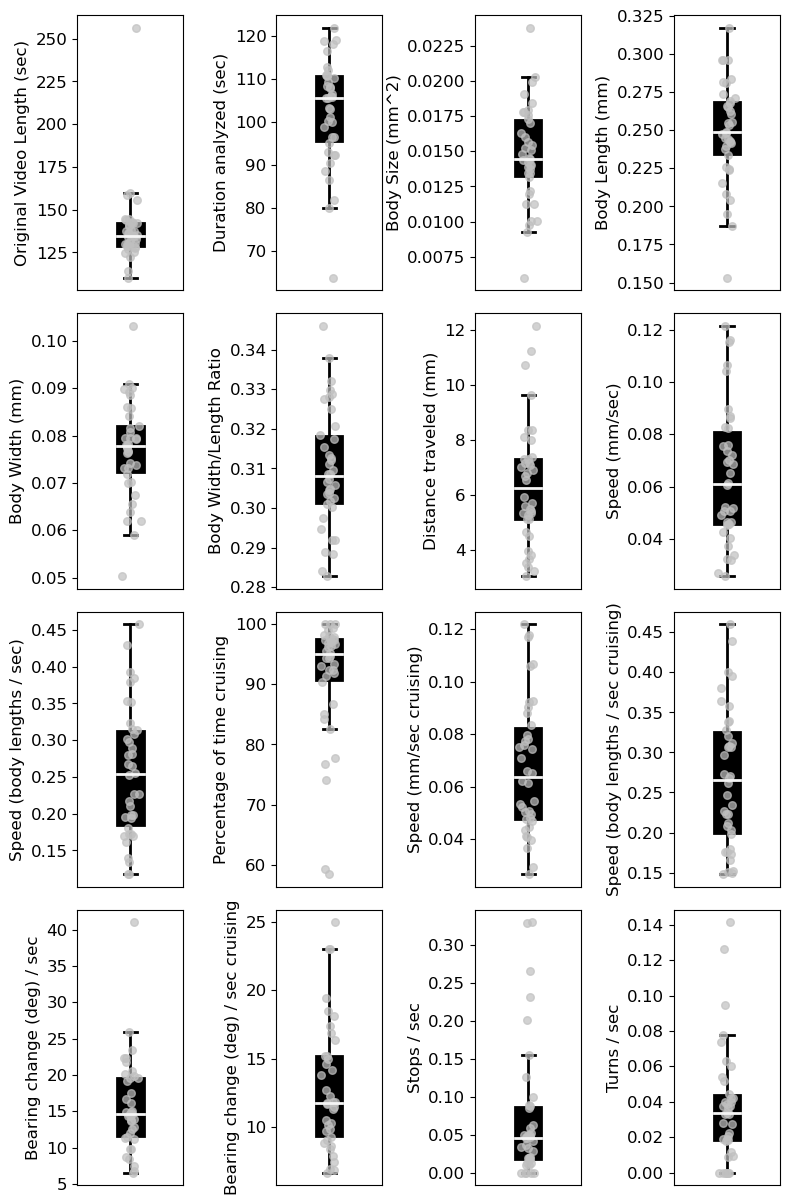

In [12]:
rows,cols = [4,4]
f,axes = plt.subplots(rows,cols,figsize = (8,12))
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = singleBoxplot(axes_list[i], path_summaries_df, col)
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

In [13]:
# make a table of the data ... can screenshot this?
means = [np.round(np.mean(path_summaries_df[col].values),2) for col in columns_to_analyze]
sds = [np.round(np.std(path_summaries_df[col].values),2) for col in columns_to_analyze]
meanstd = [str(m) + ' ± ' + str(sds[i]) for i,m in enumerate(means)]
summary_df = pd.DataFrame({'Measurement':columns_to_analyze,
                          'Mean':means,
                          'SD':sds,
                          'Mean ± Std':meanstd})
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
display(summary_df[['Measurement','Mean ± Std']])

,Measurement,Mean ± Std
,Original Video Length (sec),138.42 ± 21.92
,Duration analyzed (sec),102.3 ± 12.0
,Body Size (mm^2),0.01 ± 0.0
,Body Length (mm),0.25 ± 0.03
,Body Width (mm),0.08 ± 0.01
,Body Width/Length Ratio,0.31 ± 0.01
,Distance traveled (mm),6.37 ± 2.17
,Speed (mm/sec),0.06 ± 0.03
,Speed (body lengths / sec),0.26 ± 0.09
,Percentage of time cruising,91.3 ± 10.05


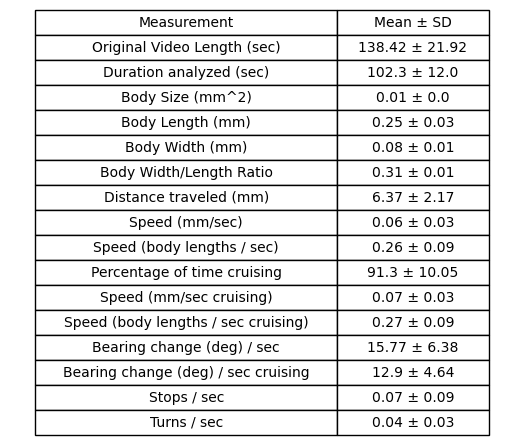

In [14]:
# table in matplotlib figure
fig,ax = plt.subplots(figsize=(6.5,4))

table_vals = np.column_stack([np.array(columns_to_analyze), summary_df['Mean ± Std'].values])
col_labels = ['Measurement','Mean ± SD']
col_colors = ['white'] * len(col_labels)

my_table = plt.table(loc='center',
                     cellText=table_vals,
                     colWidths=[0.6,0.3],
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
                     colColours=col_colors
                    )

my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
ax.axis('off')
plt.show()

In [15]:
# Table as a plotly figure
# can change colors, sizes, etc, see https://plotly.com/python/figure-factory-table/
# looks pretty good
import plotly.figure_factory as ff
fig = ff.create_table(summary_df[['Measurement','Mean ± Std']])
fig.update_layout(
    autosize=True,
    width=430,
    height=400,
)
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 11
fig.write_image("pathtrack_summary_table_plotly.png", scale=2)

In [16]:
# can also save as an excel file ... 
out_file = 'path_summaries.xlsx'
with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
    summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='path_summaries')

# Figures

In [17]:
'''Automated measurements of tardigrade length, width, and area were taken at each video frame'''
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
tardigrade = plt.imread(os.path.join('01 tracking_size','fave.png')) # or fave_with_track.png
micro = plt.imread(os.path.join('01 tracking_size','micrometer.png'))
# superimpose!
im = cv2.addWeighted(tardigrade, 0.7, micro, 0.3, 0)

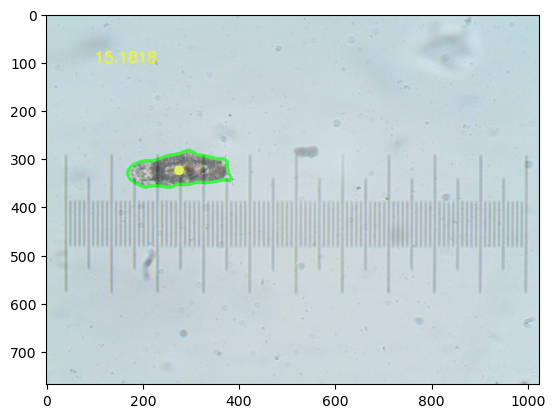

In [18]:
plt.imshow(im)
plt.show()

[8. 3.]


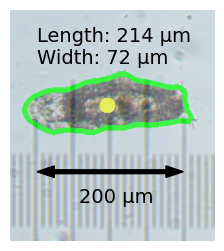

In [20]:
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm

f,ax = plt.subplots(1,1,figsize=(8,3))
im_cropped = im[150:600,:] # if labeled time and whole micrometer
# im_cropped = im[150:425,150:400]  # if just length and width

arrow_x = 280
arrow_y = 260
arrow_width = 5
dx = 95
dy = 0

# text for size and for scalebar
ax.text(arrow_x - dx,120,'Length: 214 µm\nWidth: 72 µm', color='k', fontsize=axis_fontsize)
ax.text(arrow_x-40, arrow_y+40, '200 µm', color='k', fontsize=axis_fontsize)

# arrow for scalebar
arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, dy,
                            width=arrow_width, length_includes_head=True, color='k')
ax.add_patch(arrow_right)
arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, dy,
                            width=arrow_width, length_includes_head=True, color='k')
ax.add_patch(arrow_left)

# scatter 'line' and text for timeline
# time_x = 750
# time_dx = 150
# time_y = 40
# num_points = 100
# cmap_name = 'plasma'
# cmap = cm.get_cmap(cmap_name)
# cols = cmap(np.linspace(0,1,num_points))
# ax.scatter(np.linspace(time_x,time_x+time_dx,num_points),[time_y]*num_points, c=cols, s=5)
# ax.text(time_x-90, time_y+12, 'O s', fontsize=fontsize)
# ax.text(time_x+time_dx+5, time_y+10, '15 s', fontsize=fontsize)

ax.axis('off')
ax.set_xlim([150,415]) # if include whole micrometer and tracked path
ax.set_ylim([350,50])
plt.imshow(im_cropped)
print(f.get_size_inches())
plt.show()

Length vs Width ρ = 0.89 p = 0.0
n = 38


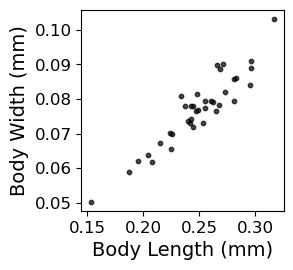

In [37]:
'''Length was strongly correlated with width'''
lengths = path_summaries_df['Body Length (mm)'].values
widths = path_summaries_df['Body Width (mm)'].values
f,ax = plt.subplots(1,1,figsize = (2.61,2.61) )
plt.scatter(lengths,widths,s=marker_size,alpha=marker_alpha,color='k')
plt.xlabel('Body Length (mm)')
plt.ylabel('Body Width (mm)')
r,p = stats.spearmanr(lengths,widths)
print('Length vs Width ρ =', np.round(r,2), 'p =', np.round(p,2))
ax.yaxis.label.set_size(axis_fontsize)
ax.xaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
print('n = ' + str(len(lengths)))
plt.show()

... getting first frame ...
... getting last frame ...
Last successful frame = 503
Percentage Cruising = 91.0


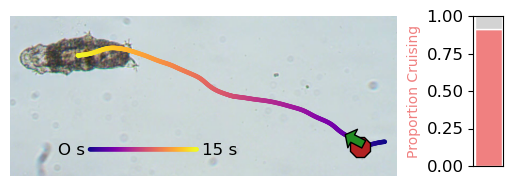

In [25]:
'''Track with Stop & Turn points'''

# rotate markers, fill markers:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html

os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/02 tracking_path')
addStopsTurns = True

cmap_name = 'plasma'
cmap = mpl.colormaps.get_cmap(cmap_name)

excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)

f = plt.figure(1, figsize=(6,2))
ax = f.add_axes([0.1, 0.1, 0.7, 0.8])

# add color bar for timeline on separate axis
# ax_colorbar = f.add_axes([0.9,0.2,0.02,0.6])   
# norm = mpl.colors.Normalize(vmin=0, vmax=tracked_df.times.values[-1])
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Time (sec)', cax = ax_colorbar)

# add fake color bar for timeline
time_x = 300
time_dx = 200
time_y = 500
num_points = 100
cols = cmap(np.linspace(0,1,num_points))
ax.scatter(np.linspace(time_x,time_x+time_dx,num_points),[time_y]*num_points, c=cols, s=5)
ax.text(time_x-60, time_y+10, 'O s', fontsize=tick_fontsize)
ax.text(time_x+time_dx+10, time_y+10, '15 s', fontsize=tick_fontsize)

# plot image of tardigrade
# combined_frame = gaitFunctions.superImposedFirstLast(movie_file)
# combined_frame = combined_frame
first_frame, last_frame = gaitFunctions.getFirstLastFrames(movie_file)
frame_to_show = last_frame
frame_to_show = frame_to_show[:, :, [2, 1, 0]]
ax.imshow(frame_to_show) # combined_frame or last_frame

# plot tardigrade path
xcoords = tracked_df.xcoords.values
ycoords = tracked_df.ycoords.values
smoothedx = tracked_df.smoothed_x.values
smoothedy = tracked_df.smoothed_y.values
cols = cmap(np.linspace(0,1,len(smoothedx)))
# ax.scatter(xcoords, ycoords, c = 'grey', s=20) # raw data 'dimgrey' or 'black' or 'slategray'
ax.scatter(smoothedx, smoothedy, c = cols, s=5) # smoothed data

# add 'cruising' percentage plot
cruisingax = f.add_axes([0.9, 0.15, 0.05, 0.75])
plotClip.cruisingProportionPlot(cruisingax, tracked_df)
cruisingax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# add stops and turns
if addStopsTurns:
    
    arrowup, arrowdown, cut_arrowup, cut_arrowdown = gaitFunctions.getArrowMarkers()
    markersize = 15
    stop_color = 'firebrick' # 'tab:red' or 'firebrick'
    turn_color = 'forestgreen' # 'limegreen' or 'tab:green' or 'green' or 'forestgreen'

    # get runs of stops ... the stop marker will be plotted in the beginning of the stop bout
    stops = tracked_df.stops.values
    stop_bouts = gaitFunctions.one_runs(stops)
    # stop_indices = [int((x[0]+x[1])/2) for x in stop_bouts] #  at middle of bout
    stop_indices = [x[0] for x in stop_bouts] # at beginning of bout
    stop_x = [smoothedx[i] for i in stop_indices]
    stop_y = [smoothedy[i] for i in stop_indices]

    # plot stops
    ax.plot(stop_x, stop_y, "8", markersize=markersize, markerfacecolor=stop_color, markeredgecolor="k")

    # get turns ... the turn marker will be plotted at the END of the turn
    turns = tracked_df.turns.values
    turn_bouts = gaitFunctions.one_runs(turns)
    turn_indices = [x[1] for x in turn_bouts]

    turn_x = [smoothedx[i] for i in turn_indices]
    turn_y = [smoothedy[i] for i in turn_indices]

    turn_directions = np.zeros(len(turn_bouts))
    for i, idx in enumerate(turn_indices):
        try:
            turn_directions[i] = np.mean(tracked_df.filtered_bearings.values[idx:idx+5])
        except:
            turn_directions[i] = tracked_df.filtered_bearings.values[idx]

    # plot turns
    for i, angle in enumerate(turn_directions):
        t = mpl.markers.MarkerStyle(marker=arrowup)
        t._transform = t.get_transform().rotate_deg(-angle)
        ax.plot(turn_x[i], turn_y[i], marker=t, markersize=markersize, markerfacecolor=turn_color, markeredgecolor="k")

ax.set_ylim([550,250])
ax.set_xlim([150,875])
ax.axis('off')
plt.show()

In [26]:
def scat(ax, x, y, xlab, ylab, col = 'tab:green'):
    ax.scatter(x,y,s=20,alpha=0.7,color=col)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    r,p = stats.spearmanr(x,y)
    print(xlab.replace('\n',' ') + ' vs. ' + ylab.replace('\n',' ') + ' ρ =', np.round(r,2), 'p =', np.round(p,2))
    return ax

Body Length (mm) vs. Cruising Speed (mm/sec) ρ = 0.45 p = 0.0
Body Area (mm$^2$) vs. Cruising Speed (mm/sec) ρ = 0.42 p = 0.01


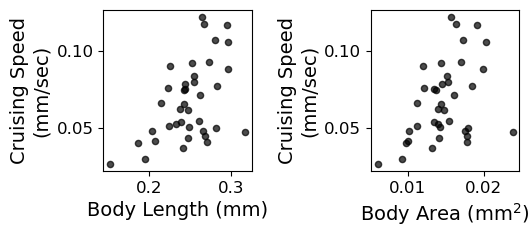

In [32]:
'''speed vs length; speed vs. area'''

fig, axes = plt.subplots(1,2, figsize=(5.5,2.5))

lengths = path_summaries_df['Body Length (mm)'].values
areas = path_summaries_df['Body Size (mm^2)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values

x = [lengths, areas]
y = [cruising_speed_mm] * 2
xlab = ['Body Length (mm)', 'Body Area (mm$^2$)']
ylab = ['Cruising Speed\n(mm/sec)'] * 2 

for i, ax in enumerate(axes.flatten()):
    ax = scat(ax, x[i], y[i], xlab[i], ylab[i], 'black')
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
plt.tight_layout()
plt.show()

Body Length (mm) vs. Cruising Speed (bodylength/sec) ρ = 0.19 p = 0.25
Width:Length Ratio vs. Cruising Speed (bodylength/sec) ρ = -0.55 p = 0.0


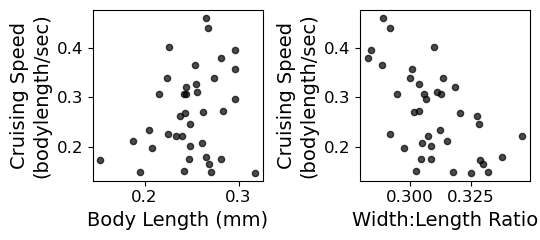

In [34]:
'''Normalized speed vs length; Normalized speed vs. width:length ratio'''

fig, axes = plt.subplots(1,2, figsize=(5.5,2.5))

lengths = path_summaries_df['Body Length (mm)'].values
ratios = path_summaries_df['Body Width/Length Ratio'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

x = [lengths, ratios]
y = [cruising_speed_bodylength] * 2
xlab = ['Body Length (mm)', 'Width:Length Ratio']
ylab = ['Cruising Speed\n(bodylength/sec)'] * 2

for i, ax in enumerate(axes.flatten()):
    ax = scat(ax, x[i], y[i], xlab[i], ylab[i], 'black')
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
plt.tight_layout()
plt.show()

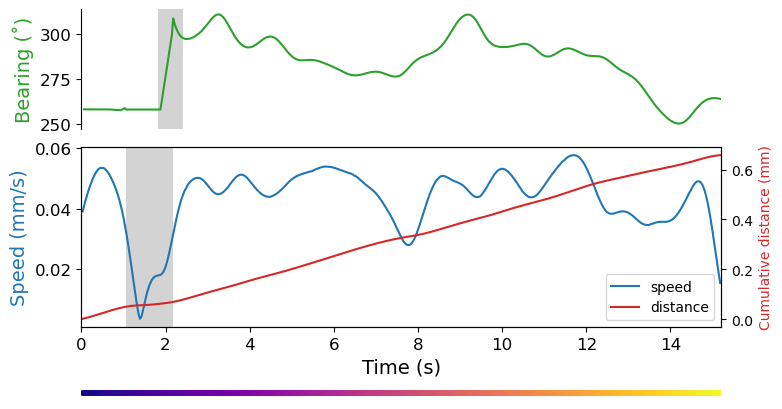

In [39]:
'''Quantification of speed, stops, turns'''
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/02 tracking_path')
f = plt.figure(1, figsize=(8,6))

excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)
path_stats = gaitFunctions.loadPathStats(movie_file)
scale = float(path_stats['scale'])
unit = path_stats['unit']

# plot time (x) vs. speed (left y axis)
speedax = f.add_axes([0.1, 0.22, 0.8, 0.3])      
speedax, distax = plotClip.speedDistancePlot(speedax, tracked_df, scale, unit)
speed_xlim = speedax.get_xlim()

# plot bearing changes on a separate axis above (a3)
bearingax = f.add_axes([0.1, 0.55, 0.8, 0.2])
bearingax = plotClip.bearingChangePlot(bearingax, tracked_df)
bearingax.set_xlim(speed_xlim)

# tiny axis to show time
timeribbonax = f.add_axes([0.1, 0.1, 0.8, 0.02])
timeribbonax = plotClip.timeRibbonPlot(timeribbonax, tracked_df)
timeribbonax.set_xlim(speed_xlim)
timeribbonax.axis('off')

# adjust plot parameters
for ax in [speedax, bearingax]:
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# show plot
plt.show()

# Sample step tracking - one clip, same time axis as above

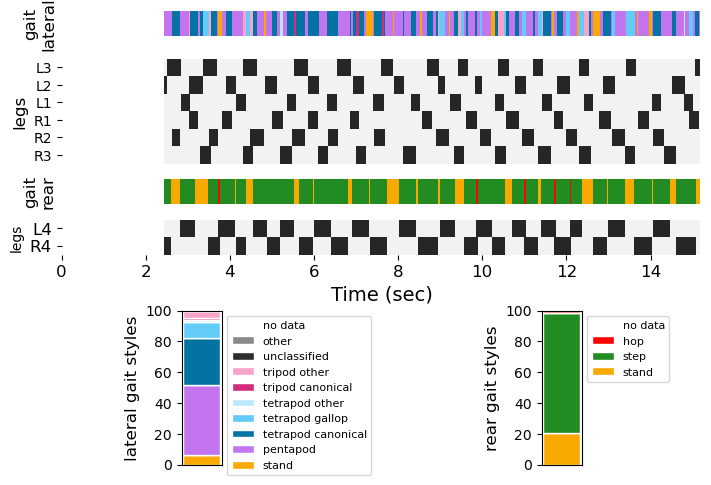

In [54]:
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/03 step_kinematics')
f = plt.figure(1, figsize=(8,7))

excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'

# plot the steps for the lateral legs
steps = f.add_axes([0.1, 0.53, 0.8, 0.15])
lateral_legs = gaitFunctions.get_leg_combos()[0]['legs_lateral']
steps = gaitFunctions.plotLegSet(steps, movie_file, lateral_legs)
steps.set_xlabel('')
steps.set_xticks([])
steps.set_xlim(speed_xlim)

# plot the gait styles for lateral legs
gaits_ax = f.add_axes([0.1, 0.71, 0.8, 0.04])
gaits_ax = gaitFunctions.plotGaits(gaits_ax, excel_filename, 'lateral')
gaits_ax.set_xlim(speed_xlim)


# plot the steps for the rear legs
rear_steps = f.add_axes([0.1, 0.4, 0.8, 0.05])
rear_legs = gaitFunctions.get_leg_combos()[0]['legs_4']
rear_steps = gaitFunctions.plotLegSet(rear_steps, movie_file, rear_legs)
rear_steps.set_xlim(speed_xlim)
# rear_steps.set_xticks([])

# plot the gait styles for rear legs
reargaits_ax = f.add_axes([0.1, 0.47, 0.8, 0.04])
reargaits_ax = gaitFunctions.plotGaits(reargaits_ax, excel_filename, 'rear')
reargaits_ax.set_xlim(speed_xlim)

# proportions and legend for gait styles: lateral
lateral_gait_proportions_ax = f.add_axes([0.25, 0.1, 0.05, 0.22])
lateral_gait_proportions_ax = gaitFunctions.gaitStylePercentagesPlot(lateral_gait_proportions_ax, 
                                                                      [excel_filename],
                                                                      'lateral')

# proportions and legend for gait styles: rear
rear_gait_proportions_ax = f.add_axes([0.7, 0.1, 0.05, 0.22])
rear_gait_proportions_ax = gaitFunctions.gaitStylePercentagesPlot(rear_gait_proportions_ax, 
                                                                      [excel_filename],
                                                                      'rear')

# adjust parameters and show plot
for ax in [steps, gaits_ax, reargaits_ax, lateral_gait_proportions_ax,rear_gait_proportions_ax]:
    ax.yaxis.label.set_size(axis_fontsize-2)
    ax.xaxis.label.set_size(axis_fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize-2)
rear_steps.xaxis.label.set_size(axis_fontsize)
rear_steps.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

# Tardigrade Size
### Nirody figure 1A, 1B

In [5]:
'''
Nirody figure 1A, 1B ... tardigrade size
they report body length 350.40 ± 46.04 (standard deviation)
n = 43 tardigrades

the tardigrade they show in 1B looks like a young one, with no eggs . . . 
but ours are smaller? See confirmation of size measurements a few cells down.

Also see 'tardigrade size check' folder in analyses_summaries
''' 

# load the path summaries data into a dataframe
path_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
num_tardigrades = len(path_df.individual.values)
body_lengths = path_df['Body Length (mm)'].values * 1000
body_length = np.round(np.mean(body_lengths),2)
body_length_sd = np.round(np.std(body_lengths),2)

print('n = ' + str(num_tardigrades) + ' tardigrades')
print('body length = ' + str(body_length) + ' ± ' + str(body_length_sd) + ' µm')


n = 38 tardigrades
body length = 248.94 ± 32.62 µm


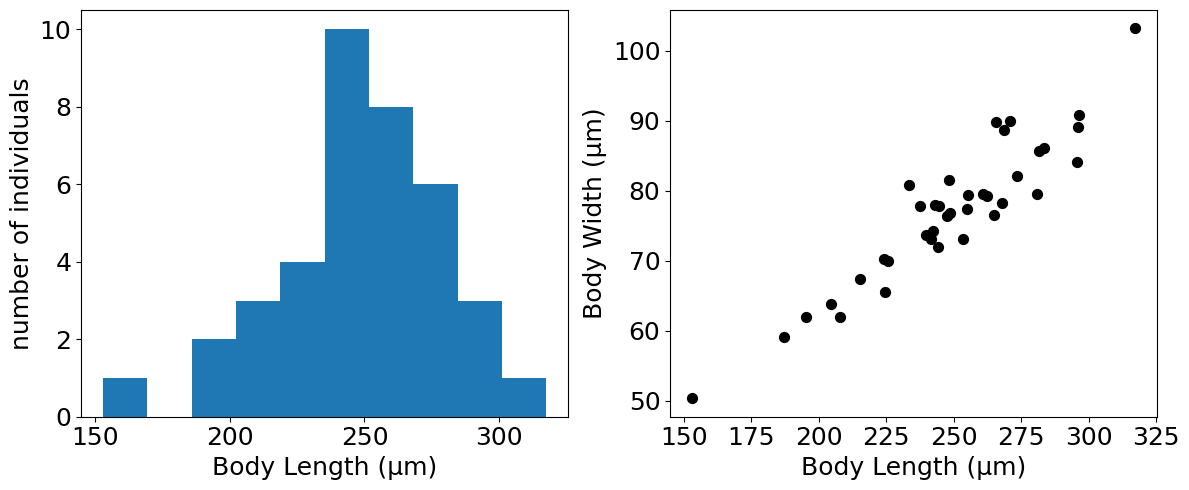

In [6]:
# more about size ... 
f,(a1,a2) = plt.subplots(1,2,figsize=(12,5))
a1.hist(body_lengths)
a1.set_ylabel('number of individuals',fontsize=18)
a1.set_xlabel('Body Length (µm)', fontsize=18)
a1.tick_params(axis='x', labelsize=18)
a1.tick_params(axis='y', labelsize=18)
body_widths = path_df['Body Width (mm)'].values * 1000
a2.scatter(body_lengths,body_widths,s=50,c='k')
a2.set_ylabel('Body Width (µm)',fontsize=18)
a2.set_xlabel('Body Length (µm)',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.tight_layout()
plt.show()

# Looking at size differences
Sizes are different between Nirody paper and our analyses ... <br>

Summary of analysis below - if our pix-per-mm 'scales' are correct (and they seem to be), our sizes are correct.

Re-check our size measurements: <br>

On images from the Amscope inverted scope with MD310B camera, capturing images at 1024x768.<br>
Measuring micrometer via Python = <br>
* about 957 pixels (956 on 8 Dec, 948 on 12 Dec, 957 on 14 Dec, 958 on 30 Jan, 955 on 1 Feb)<br>
* Confirmed these values on Preview app, Confirmed on FIJI<br><br>

Selected three tardigrades from 9Nov23 (AmScope) <br>
to measure pixels in FIJI and compare to PYTHON-calculated values:<br>
* iw_9Nov_tardigrade01_exemplaris_033-060_first  145 pix = 151.67 µm (FIJI) vs. 155.98 µm (path_stats)
* iw_9Nov_tardigrade02_exemplaris_080-087_first  230 pix = 240.58 µm (FIJI) vs. 253.72 µm (path_stats)
* iw_9Nov_tardigrade04_exemplaris_097-117_first  261 pix = 273.01 µm (FIJI) vs. 280.70 µm (path_stats)
<br>

On images from the Te-Wen inverted scope with Te-Wen camera, capturing images at 1920x1080.<br>
Measuring micrometer via Python = <br>
* about 1633 pixels (1637 in adults_15Sep, 1631 in babies_15Sep, 1633 in adults_28Nov)
* Confirmed these values on Preview app, Confirmed on FIJI<br><br>

Selected three tardigrades from 28Nov23 (Te-Wen Scope and camera) <br> 
to measure pixels in FIJI and compare to PYTHON-calculated values:<br>
* ea_16jul_tardigrade37A-day4_050-068_first  229.12 pix = 140.30 µm (FIJI) vs. 144.04 µm (path_stats)
* ea_28nov_exemplaris_tardigrade15_027-035_first  497.29 pix = 304.52 µm (FIJI) vs. 289.14 µm (path_stats)
* gi_15sep_tardigrade8_041-070_first  341.71 pix = 209.25 µm (FIJI) vs. 201.17 µm (path_stats)